In [1]:
import numpy as np 
import pandas as pd 
import re, itertools, json, os, random, contractions, nltk, warnings
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob as TB
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from wordcloud import WordCloud
from collections import Counter
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from datetime import datetime
from bs4 import BeautifulSoup
from textblob import Word
# Essential imports

import numpy as np
import pandas as pd 
import re
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
import matplotlib.pyplot as plt

# Data Acquisition

In [2]:
traindataset = pd.read_csv("C:/Users/varni/Desktop/6th sem mini project+ppt/train_nykaa_product_review.csv")
testdataset = pd.read_csv("C:/Users/varni/Desktop/6th sem mini project+ppt/test_nykaa_product_review.csv")
frames = [traindataset,testdataset]
alldataset = pd.concat(frames)

In [3]:
traindataset.shape

(155544, 2)

In [4]:
alldataset.dropna(inplace = True)
alldataset=alldataset.rename(columns={'content': 'reviews', 'sentiment_labels': 'sentiments'})
alldataset.head()

,reviews,sentiments
0,Nice shopping app,POSITIVE
1,Nykaa you yuyz are not giving my reward points...,NEGATIVE
2,Love it,POSITIVE
3,Is cod available?,NEGATIVE
4,Its awesome,POSITIVE


In [5]:
alldatasetdl=alldataset

# Data Preprocessing

## Text Data Analysis

In [6]:
def sentiment_analyzer(x):
    if x<0.3:
        return -1
    elif x>0.55:
        return 1
    else:
        return 0

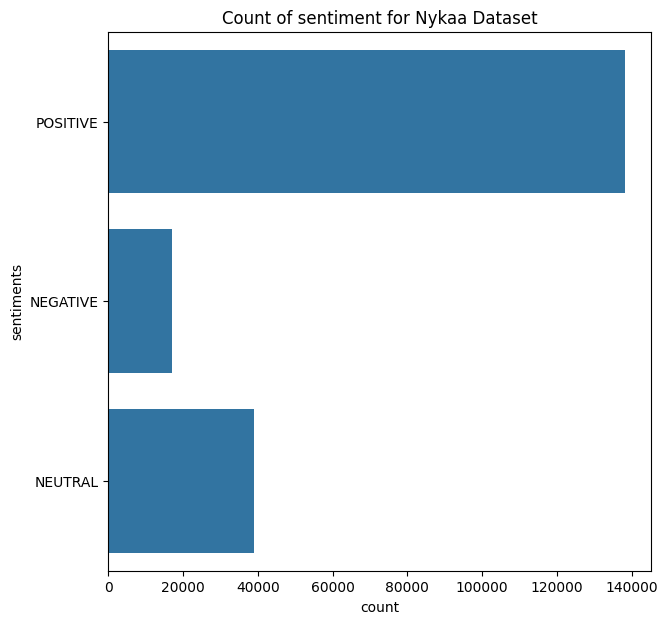

In [7]:
plt.figure(figsize = (7,7))
plt.title('Count of sentiment for Nykaa Dataset')
sns.countplot(alldataset.sentiments)
plt.show()

In [9]:
# to tackle first task lets define a useFul 
# Function
def WordCloudForsentiments (alldataset, sentiments):
    df =  (alldataset[alldataset['sentiments'] == sentiments]['reviews'])
    corpus = ''
    
    for mem in df:
        corpus += mem
    
    corpus = re.sub('READ MORE', '', corpus)
    wordcloud = WordCloud(width = 900, height = 800,background_color ='white',
                          stopwords = stopwords,  min_font_size = 10).generate(corpus)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.rcParams.update({'font.size': 25})
    plt.axis("off") 
    plt.title('Word Cloud:  ' + sentiments + ' Sentiment reviews')
    plt.tight_layout(pad = 0) 
  
    plt.show() 
    plt.figure(figsize=(12, 8))
    

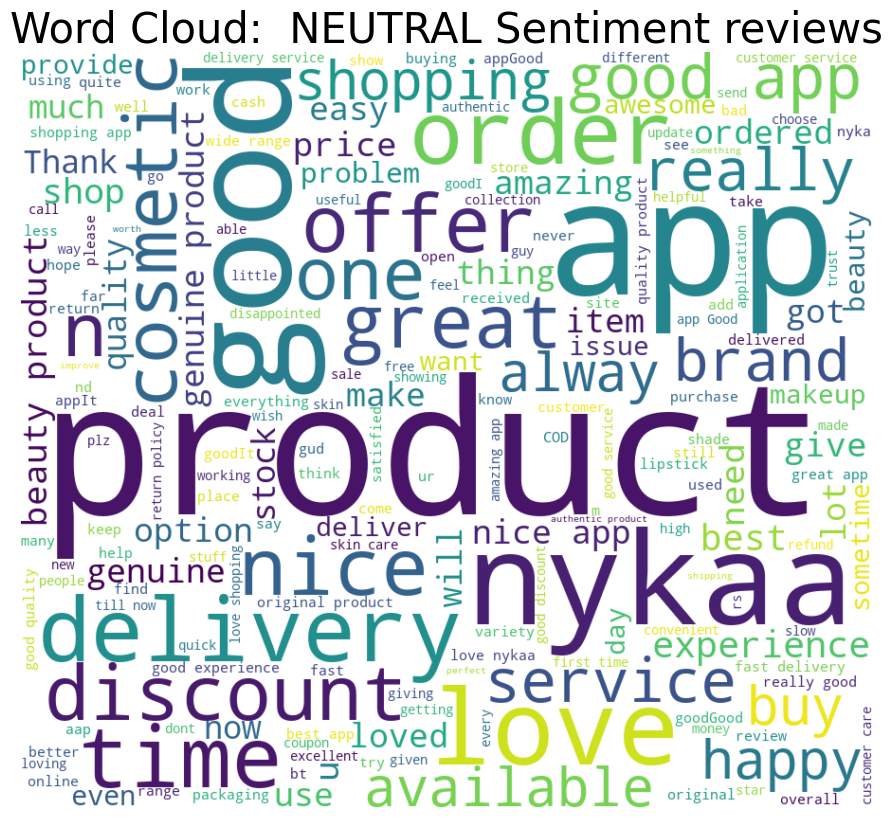

<Figure size 1200x800 with 0 Axes>

In [10]:
sentiments=['NEUTRAL','POSITIVE','NEGATIVE']
# word cloud for 1 star products
WordCloudForsentiments(alldataset,sentiments[0])

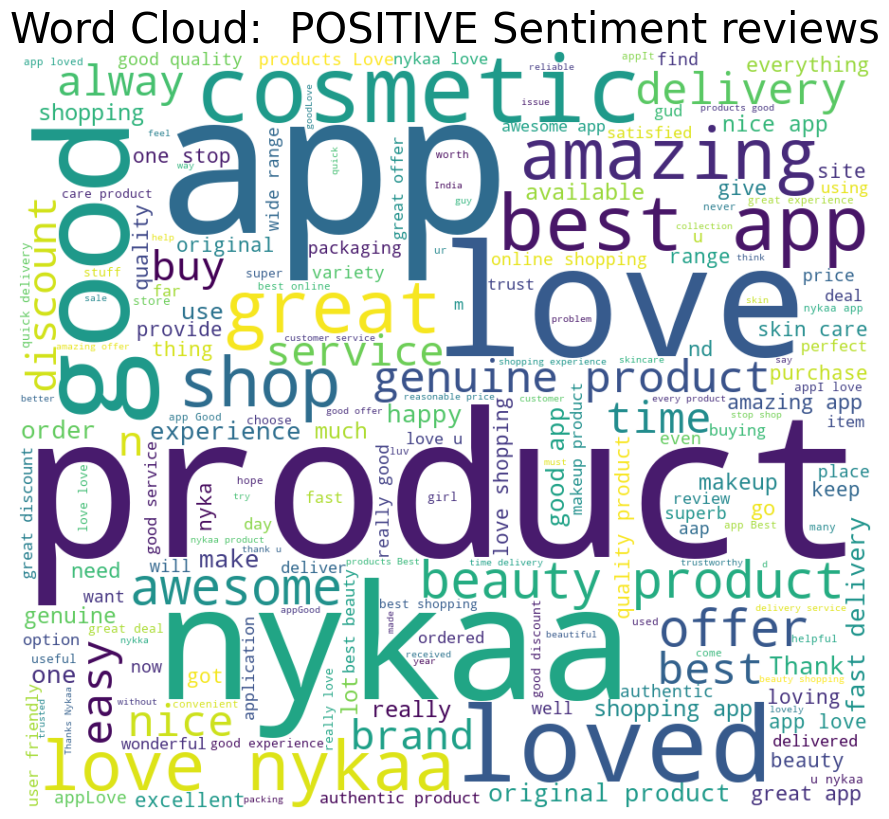

<Figure size 1200x800 with 0 Axes>

In [11]:
# word cloud for 2 positive product reviews
WordCloudForsentiments(alldataset, sentiments[1])

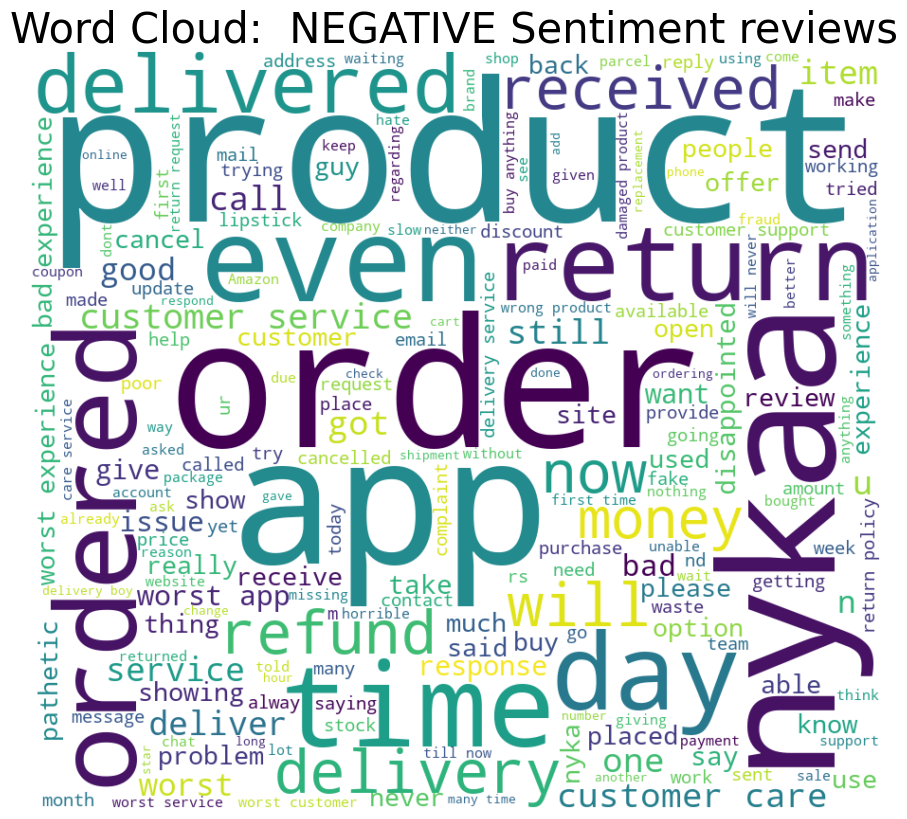

<Figure size 1200x800 with 0 Axes>

In [12]:
# word cloud for 3 negative product reviews
WordCloudForsentiments(alldataset, sentiments[2])

In [13]:
import contractions
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

In [14]:
alldataset.dropna(inplace = True)
alldataset = alldataset.reset_index(drop = True)

In [15]:
alldataset.reviews = alldataset.reviews.map(lambda x: denoise_text(x))        
# alldataset.reviews = alldataset.reviews.map(lambda x: replace_contractions(x))
alldataset.reviews = alldataset.reviews.str.replace('[^\w\s]',' ')
alldataset.reviews = alldataset.reviews.apply(lambda x: " ".join(x.lower() for x in x.split()))

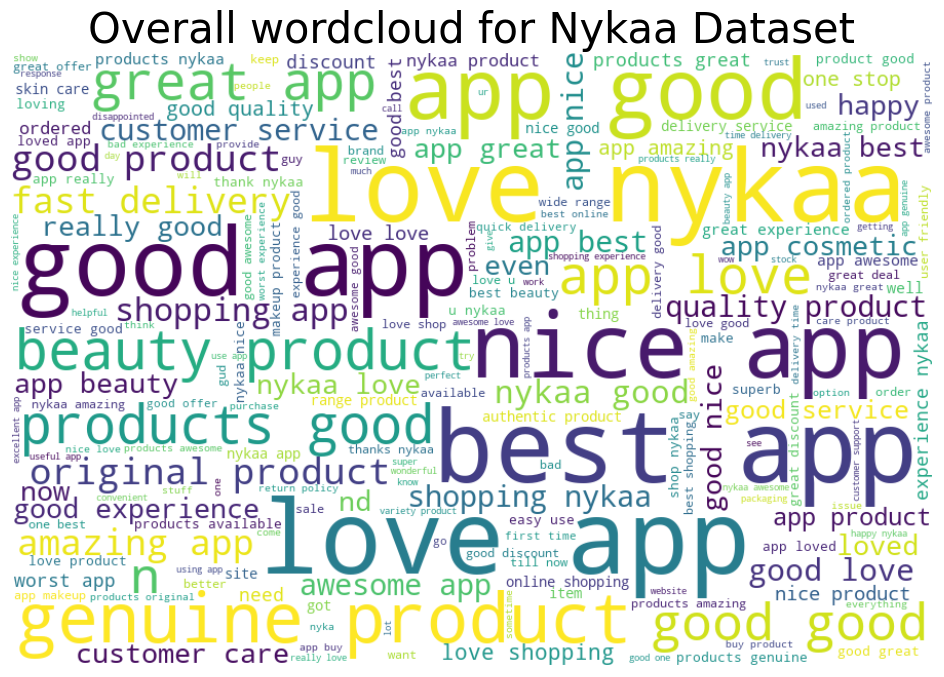

In [16]:
stopset = stopwords
alldataset_words = ' '.join([text for text in alldataset.reviews])
alldataset_words = ' '.join([w for w in alldataset_words.split() if not w in stopset])
wordcloud = WordCloud(background_color = "white",width=900, height=600, random_state=21, max_font_size=100).generate(alldataset_words)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Overall wordcloud for Nykaa Dataset')
plt.axis('off')
plt.show()

In [17]:
!pip install contractions

In [18]:
import contractions
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

In [19]:
alldataset.dropna(inplace = True)
alldataset= alldataset.reset_index(drop = True)

In [20]:
alldataset.reviews = alldataset.reviews.map(lambda x: denoise_text(x))        
alldataset.reviews = alldataset.reviews.map(lambda x: replace_contractions(x))
alldataset.reviews = alldataset.reviews.str.replace('[^\w\s]',' ')
alldataset.reviews = alldataset.reviews.apply(lambda x: " ".join(x.lower() for x in x.split()))

# Data Transformation

In [21]:
## lets predict Product sentimentss 
## will be using mutliclass classification for 
## for our Purposue

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
text = alldataset['reviews']
label = alldataset['sentiments']

## Converting data to numpy array
## for ease of analysis

text = np.array(text)
labels = np.array(label)
le = preprocessing.LabelEncoder()
label=le.fit_transform(label)
## also labels are from 1-5
## tf expects 0-4
## hence this

## splitting to train and test sets
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size = 0.1, random_state = 42)
X_trainML, X_tesML, y_trainML, y_testML = train_test_split(text, labels, test_size = 0.1, random_state = 42)
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen = 50)
X_test = pad_sequences(X_test, maxlen = 50)
len(tokenizer.word_index)
epochs = 100
emb_dim = 50
batch_size = 256
n_most_common_words=10000



# Machine Learning Models

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mlresults(modelname , y_test,pred):
  accuracy = metrics.accuracy_score(y_testML,pred)
  confusion_matrix = metrics.confusion_matrix(y_test,pred)
  classification = metrics.classification_report(y_test,pred)
  print('============================== {} Model Test Results =============================='.format(modelname))
  print()
  print ("Model Accuracy:" "\n", accuracy)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 
  print()  

In [23]:
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, y_trainML)
knnpred =KNN_Classifier.predict(X_test)
mlresults('KNN' , y_testML,knnpred)

============================== KNN Model Test Results ==============================

Model Accuracy:
 0.6833821941058479

Confusion matrix:
 [[  576   187   949]
 [  186   430  3318]
 [  385  1131 12281]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.50      0.34      0.40      1712
     NEUTRAL       0.25      0.11      0.15      3934
    POSITIVE       0.74      0.89      0.81     13797

    accuracy                           0.68     19443
   macro avg       0.50      0.45      0.45     19443
weighted avg       0.62      0.68      0.64     19443




In [24]:
# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier=LGR_Classifier.fit(X_train, y_trainML)
lgrpred =LGR_Classifier.predict(X_test)
mlresults('LGR' , y_testML,lgrpred)

============================== LGR Model Test Results ==============================

Model Accuracy:
 0.7237051895283649

Confusion matrix:
 [[  440    29  1243]
 [  124     5  3805]
 [  159    12 13626]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.61      0.26      0.36      1712
     NEUTRAL       0.11      0.00      0.00      3934
    POSITIVE       0.73      0.99      0.84     13797

    accuracy                           0.72     19443
   macro avg       0.48      0.42      0.40     19443
weighted avg       0.59      0.72      0.63     19443




In [25]:
# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier = BNB_Classifier.fit(X_train, y_trainML)
BNBpred =BNB_Classifier.predict(X_test)
mlresults('BNB' , y_testML,BNBpred)

============================== BNB Model Test Results ==============================

Model Accuracy:
 0.6898626755130381

Confusion matrix:
 [[ 1048    41   623]
 [  532   102  3300]
 [ 1277   257 12263]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.61      0.46      1712
     NEUTRAL       0.26      0.03      0.05      3934
    POSITIVE       0.76      0.89      0.82     13797

    accuracy                           0.69     19443
   macro avg       0.46      0.51      0.44     19443
weighted avg       0.62      0.69      0.63     19443




In [26]:
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier=DTC_Classifier.fit(X_train, y_trainML)
dtcpred =DTC_Classifier.predict(X_test)
mlresults('DTC' , y_testML,dtcpred)

============================== DTC Model Test Results ==============================

Model Accuracy:
 0.6623977781206604

Confusion matrix:
 [[  739   331   642]
 [  300   557  3077]
 [  580  1634 11583]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.46      0.43      0.44      1712
     NEUTRAL       0.22      0.14      0.17      3934
    POSITIVE       0.76      0.84      0.80     13797

    accuracy                           0.66     19443
   macro avg       0.48      0.47      0.47     19443
weighted avg       0.62      0.66      0.64     19443




In [27]:
SVM_Classifier = SVC()
SVM_Classifier = SVM_Classifier.fit(X_train[:38886], y_trainML[:38886])
svmpred =SVM_Classifier.predict(X_test)
mlresults('SVM' , y_testML,svmpred)

============================== SVM Model Test Results ==============================

Model Accuracy:
 0.7280255104664918

Confusion matrix:
 [[  635     4  1073]
 [  183     0  3751]
 [  271     6 13520]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.58      0.37      0.45      1712
     NEUTRAL       0.00      0.00      0.00      3934
    POSITIVE       0.74      0.98      0.84     13797

    accuracy                           0.73     19443
   macro avg       0.44      0.45      0.43     19443
weighted avg       0.57      0.73      0.64     19443




In [28]:
RandomForest_Classifier = RandomForestClassifier(n_estimators=800)
RandomForest_Classifier.fit(X_train, y_trainML)
rfpred =RandomForest_Classifier.predict(X_test)
mlresults('RF' , y_testML,rfpred)

============================== RF Model Test Results ==============================

Model Accuracy:
 0.7308028596410019

Confusion matrix:
 [[  807    34   871]
 [  227   148  3559]
 [  264   279 13254]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.62      0.47      0.54      1712
     NEUTRAL       0.32      0.04      0.07      3934
    POSITIVE       0.75      0.96      0.84     13797

    accuracy                           0.73     19443
   macro avg       0.56      0.49      0.48     19443
weighted avg       0.65      0.73      0.66     19443




In [29]:
model1 = RandomForestClassifier()
model2 = KNeighborsClassifier()
model3 = LogisticRegression()
Voting = VotingClassifier(estimators=[('RF', model1 ), ('knn', model2),('lr',model3)], voting='hard')
Voting.fit(X_train, y_trainML) 
vepred =Voting.predict(X_test)
mlresults('Voting' , y_testML,vepred)

============================== Voting Model Test Results ==============================

Model Accuracy:
 0.7303914005040374

Confusion matrix:
 [[  674    21  1017]
 [  176    84  3674]
 [  238   116 13443]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.62      0.39      0.48      1712
     NEUTRAL       0.38      0.02      0.04      3934
    POSITIVE       0.74      0.97      0.84     13797

    accuracy                           0.73     19443
   macro avg       0.58      0.46      0.45     19443
weighted avg       0.66      0.73      0.65     19443


